In [50]:
# If you are using Python 2 version
'''from __future__ import absolute_import
from __future__ import print_function'''

# Fundamental Libraries for Machine Learning
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Tensorflow Libraries
import tensorflow as tf
import tensorflow.keras as keras
# MNIST Dataset
from keras.datasets import mnist

In [51]:
NUM_CLASS = 10        # Number of classified objects (labels)
NUM_EPOCH = 20        # How many epoch will be used for model training
IMG_SIZE = (28,28)    # Input Image size
CONT_MARGIN = 1       # Contrastive Loss margin

#### Load MNIST Dataset

In [52]:
# Split data into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [53]:
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

x_train.shape:  (60000, 28, 28)
x_test.shape:  (10000, 28, 28)
y_train.shape:  (60000,)
y_test.shape:  (10000,)


In [54]:
# Reshape the x_train and the x_test set from (60000, 28, 28) to (60000, 28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [55]:
print("x_train.shape: ", x_train.shape)
print("x_test.shape: ", x_test.shape)

x_train.shape:  (60000, 28, 28, 1)
x_test.shape:  (10000, 28, 28, 1)


In [56]:
# Set all split sets' data type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Normalize x_train and the x_test data
x_train /= 255
x_test /= 255
 
input_shape = x_train.shape[1:]
input_shape

(28, 28, 1)

In [57]:
# This method converts given array to the image with given width/height values
def convert_matrix_to_img(data_array, w_h, tag=None, show=False):
    img = np.reshape(data_array, w_h)
    if(show == True):
        if tag is not None:
            plt.title("The image of "+ tag +" from MNIST-Fashion Dataset")
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.show()
    return img

In [58]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
   
  n = min([len(digit_indices[d]) for d in range(NUM_CLASS)]) -1   # digit_indices is the y_train array indexes that included the stated label images
  # n represents minimum classified number size of the dataset (i.e. The dataset may include 9000 5 images and 7000 3 images)
  # n is equal to 5421 (Label 5) for this dataset

  for d in range(NUM_CLASS):   # 10
    for i in range(n):         # 5420
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]   # The pair that consist images took from same class
      pairs += [[x[z1], x[z2]]]    # 5420 img * 10 class = 54200 img

      inc = random.randrange(1, NUM_CLASS)   # Select other classes
      dn = (d + inc) % NUM_CLASS

      z1, z2 = digit_indices[d][i], digit_indices[dn][i]    # The pair that consist images took from different classes
      pairs += [[x[z1], x[z2]]]    # 5420 img * 10 class = 54200 img
      labels += [1,0]
      # len(pairs) = 54200 + 54200 = 108400
      # len(labels) = 108400
  return np.array(pairs), np.array(labels)

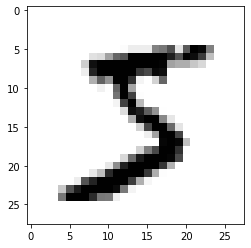

Label of the first training image 5


In [59]:
first_trained_img = convert_matrix_to_img(x_train[0], IMG_SIZE, show=True)
print("Label of the first training image", int(y_train[0]))

In [60]:
digit_indices = [np.where(y_train == i)[0] for i in range(NUM_CLASS)]  # digit_indices is the y_train array indexes that included the stated label images
digit_indices

[array([    1,    21,    34, ..., 59952, 59972, 59987]),
 array([    3,     6,     8, ..., 59979, 59984, 59994]),
 array([    5,    16,    25, ..., 59983, 59985, 59991]),
 array([    7,    10,    12, ..., 59978, 59980, 59996]),
 array([    2,     9,    20, ..., 59943, 59951, 59975]),
 array([    0,    11,    35, ..., 59968, 59993, 59997]),
 array([   13,    18,    32, ..., 59982, 59986, 59998]),
 array([   15,    29,    38, ..., 59963, 59977, 59988]),
 array([   17,    31,    41, ..., 59989, 59995, 59999]),
 array([    4,    19,    22, ..., 59973, 59990, 59992])]

For example the 5th index of the array includes image indexes of label 5

In [61]:
digit_indices = [np.where(y_train == i)[0] for i in range(NUM_CLASS)]   # digit_indices is the y_train array indexes that included the stated label images
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(NUM_CLASS)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [62]:
np.array(np.where(y_train.astype('int32') == 0))[0]    # The class indexes in train dataset for label 0 

array([    1,    21,    34, ..., 59952, 59972, 59987])

In [63]:
for i in range(NUM_CLASS):
    print("Label {0} image sample number: ".format(i), end="")
    print(len(np.where(y_train.astype('int32') == i)[0]))

Label 0 image sample number: 5923
Label 1 image sample number: 6742
Label 2 image sample number: 5958
Label 3 image sample number: 6131
Label 4 image sample number: 5842
Label 5 image sample number: 5421
Label 6 image sample number: 5918
Label 7 image sample number: 6265
Label 8 image sample number: 5851
Label 9 image sample number: 5949


x_train.shape:  (60000, 28, 28, 1)
Minimum image sample number for any class:  5421
The class that contains minimum image sample:  5
tr_pairs.shape:  (108400, 2, 28, 28, 1)
tr_y.shape:  (108400,)
te_pairs.shape:  (17820, 2, 28, 28, 1)
te_y.shape:  (17820,)


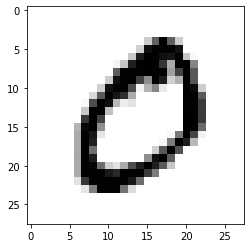

In [64]:
print("x_train.shape: ", x_train.shape)
print("Minimum image sample number for any class: ", (min([len([np.where(y_train == i)[0] for i in range(NUM_CLASS)][d]) for d in range(NUM_CLASS)]))) 
print("The class that contains minimum image sample: ", (np.argmin([len([np.where(y_train == i)[0] for i in range(NUM_CLASS)][d]) for d in range(NUM_CLASS)]))) 
print("tr_pairs.shape: ", tr_pairs.shape)
print("tr_y.shape: ", tr_y.shape)
print("te_pairs.shape: ", te_pairs.shape)
print("te_y.shape: ", te_y.shape)
tr_pairs_img = convert_matrix_to_img(tr_pairs[0][0], IMG_SIZE, show=True)

In [65]:
print("tr_pairs.shape:              ", tr_pairs.shape)
print("tr_pairs[0].shape:           ", tr_pairs[0].shape)
print("tr_pairs[0][0].shape:        ", tr_pairs[0][0].shape)
print("tr_pairs[0][0][0].shape:     ", tr_pairs[0][0][0].shape)
print("tr_pairs[0][0][0][0].shape:  ", tr_pairs[0][0][0][0].shape)

tr_pairs.shape:               (108400, 2, 28, 28, 1)
tr_pairs[0].shape:            (2, 28, 28, 1)
tr_pairs[0][0].shape:         (28, 28, 1)
tr_pairs[0][0][0].shape:      (28, 1)
tr_pairs[0][0][0][0].shape:   (1,)


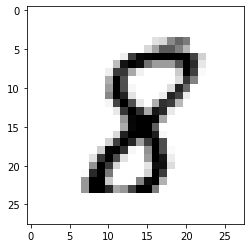

In [68]:
tr_pairs_img = convert_matrix_to_img(tr_pairs[197][1], IMG_SIZE, show=True)
# If the first array index is even number like tr_pairs[4], both tr_pairs[4][0] and tr_pairs[4][1] pairs have 0 label
# If the first array index is odd number like tr_pairs[3], tr_pairs[4][0] pair has another label and tr_pairs[4][1] pair has 0 label